In [1]:
import pandas as pd
import collections
import seaborn as sns

In [2]:
diff = pd.read_csv("./train_data/diff.csv")
diff.head()

subject  run  clip task  order    engage     enjoy  successful   control  \
0      S1    2     1  A-F      1  1.198289  1.560379    1.673320  2.357023   
1     S11    4     1  A-F      2  1.082947  0.000000    0.942809  0.749269   
2     S13    3     1  A-F      2  0.000000  0.000000   -1.037749  0.808122   
3     S15    3     1  A-F      1  2.728884  0.685994    1.000000  1.692228   
4     S17    3     1  A-F      2  0.483046  1.591434    0.448014  1.184863   

      clear  discomfort   reality         v         a         d  
0  1.009050   -1.535544  0.664037  0.644061  0.952304  0.530478  
1  0.974245    0.336350  0.000000  0.966092  1.800206  0.784465  
2 -1.141195    1.467599 -0.593465 -0.413828  0.331042  0.413828  
3  2.575185   -1.716790  1.503359 -1.828465  0.000000  0.737353  
4  0.858395   -0.974245 -1.711792  1.877359  1.992110  2.728884

In [3]:
# A-F -> 1, P-F -> 0 encoding
diff["task"].replace({"P-F":0, "A-F":1}, inplace=True)
diff.head()

subject  run  clip  task  order    engage     enjoy  successful   control  \
0      S1    2     1     1      1  1.198289  1.560379    1.673320  2.357023   
1     S11    4     1     1      2  1.082947  0.000000    0.942809  0.749269   
2     S13    3     1     1      2  0.000000  0.000000   -1.037749  0.808122   
3     S15    3     1     1      1  2.728884  0.685994    1.000000  1.692228   
4     S17    3     1     1      2  0.483046  1.591434    0.448014  1.184863   

      clear  discomfort   reality         v         a         d  
0  1.009050   -1.535544  0.664037  0.644061  0.952304  0.530478  
1  0.974245    0.336350  0.000000  0.966092  1.800206  0.784465  
2 -1.141195    1.467599 -0.593465 -0.413828  0.331042  0.413828  
3  2.575185   -1.716790  1.503359 -1.828465  0.000000  0.737353  
4  0.858395   -0.974245 -1.711792  1.877359  1.992110  2.728884

In [4]:
v1_diff = diff.loc[diff["clip"] == 1]
v2_diff = diff.loc[diff["clip"] == 2]
v4_diff = diff.loc[diff["clip"] == 4]

In [5]:
# drop unnecessary columns
drop_col = ["subject", "run", "clip", "order"]
v1_diff = v1_diff.drop(drop_col, axis=1)
v2_diff = v2_diff.drop(drop_col, axis=1)
v4_diff = v4_diff.drop(drop_col, axis=1)

### libraries for feature selection

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
import itertools

## video 1 

### Logistic Regression

In [7]:
v1_diff["task"].value_counts()

0    16
1    13
Name: task, dtype: int64

In [8]:
questions = ["engage", "enjoy", "successful", "control", "clear", "discomfort", "reality", "v", "a", "d"]
four_fold = StratifiedKFold(n_splits=4)
y = v1_diff["task"]

In [9]:
features_list = []
for L in range(1, len(questions)+1):
    for s in itertools.combinations(questions, L):
        selection = list(s)
        X = v1_diff[selection]
        cv_score = cross_val_score(LogisticRegression(), X, y, cv=four_fold, scoring='accuracy').mean()
        if cv_score >= 0.8:
            print("selection:", selection, " - accuracy:", cv_score)
            features_list += selection 

selection: ['engage', 'control', 'discomfort', 'v']  - accuracy: 0.8303571428571429
selection: ['engage', 'successful', 'discomfort', 'reality', 'v']  - accuracy: 0.8258928571428572


In [10]:
freq_counter = collections.Counter(features_list)
freq_df = pd.DataFrame({"question":list(freq_counter.keys()), "frequency":list(freq_counter.values())})
freq_df = freq_df.sort_values("frequency", ascending=False)
freq_df.reset_index(drop=True, inplace=True)
freq_df.head()

frequency    question
0          2      engage
1          2  discomfort
2          2           v
3          1     control
4          1  successful

[Text(0,0,'engage'),
 Text(0,0,'discomfort'),
 Text(0,0,'v'),
 Text(0,0,'control'),
 Text(0,0,'successful'),
 Text(0,0,'reality')]

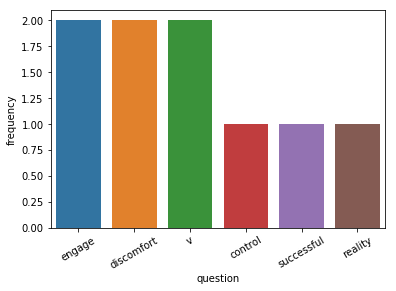

In [11]:
g = sns.barplot(x="question", y="frequency", data=freq_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

### Random Forest

In [18]:
questions = ["engage", "enjoy", "successful", "control", "clear", "discomfort", "reality", "v", "a", "d"]
four_fold = StratifiedKFold(n_splits=4)
y = v1_diff["task"]

In [19]:
features_list = []
sel_acc_list = []
for L in range(1, len(questions)+1):
    for s in itertools.combinations(questions, L):
        selection = list(s)
        X = v1_diff[selection]
        cv_score = cross_val_score(RandomForestClassifier(), X, y, cv=four_fold, scoring='accuracy').mean()
        if cv_score >= 0.8:
            print("selection:", selection, " - accuracy:", cv_score)
            features_list += selection 
            sel_acc_list.append((selection, cv_score))

selection: ['engage', 'control']  - accuracy: 0.8303571428571429
selection: ['engage', 'v']  - accuracy: 0.8392857142857143
selection: ['engage', 'successful', 'v']  - accuracy: 0.8303571428571429
selection: ['engage', 'control', 'v']  - accuracy: 0.8303571428571429
selection: ['enjoy', 'control', 'clear']  - accuracy: 0.8303571428571429
selection: ['successful', 'clear', 'discomfort']  - accuracy: 0.8616071428571429
selection: ['clear', 'discomfort', 'v']  - accuracy: 0.8303571428571429
selection: ['engage', 'successful', 'clear', 'v']  - accuracy: 0.8258928571428572
selection: ['engage', 'control', 'discomfort', 'a']  - accuracy: 0.8303571428571429
selection: ['successful', 'control', 'discomfort', 'reality']  - accuracy: 0.8303571428571429
selection: ['engage', 'successful', 'control', 'clear', 'discomfort']  - accuracy: 0.8303571428571429
selection: ['engage', 'successful', 'control', 'discomfort', 'v']  - accuracy: 0.8258928571428572
selection: ['engage', 'clear', 'discomfort', 'r

In [20]:
freq_counter = collections.Counter(features_list)
freq_df = pd.DataFrame({"question":list(freq_counter.keys()), "frequency":list(freq_counter.values())})
freq_df = freq_df.sort_values("frequency", ascending=False)
freq_df.reset_index(drop=True, inplace=True)
freq_df.head()

frequency    question
0         11      engage
1         10  discomfort
2          9     control
3          9           v
4          9  successful

[Text(0,0,'engage'),
 Text(0,0,'discomfort'),
 Text(0,0,'control'),
 Text(0,0,'v'),
 Text(0,0,'successful'),
 Text(0,0,'clear'),
 Text(0,0,'reality'),
 Text(0,0,'enjoy'),
 Text(0,0,'a')]

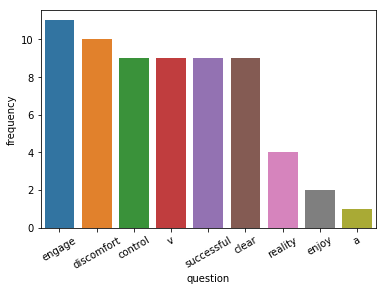

In [21]:
g = sns.barplot(x="question", y="frequency", data=freq_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

In [23]:
sel_acc_list.sort(key=lambda t: t[1], reverse=True)
top_five = sel_acc_list[0:5]
for t in top_five:
    print("selection:", t[0], "- acc:", t[1])

selection: ['successful', 'clear', 'discomfort'] - acc: 0.8616071428571429
selection: ['engage', 'v'] - acc: 0.8392857142857143
selection: ['engage', 'control'] - acc: 0.8303571428571429
selection: ['engage', 'successful', 'v'] - acc: 0.8303571428571429
selection: ['engage', 'control', 'v'] - acc: 0.8303571428571429


## video 2

### Logistic Regression

In [24]:
v2_diff["task"].value_counts()

1    15
0    14
Name: task, dtype: int64

In [25]:
questions = ["engage", "enjoy", "successful", "control", "clear", "discomfort", "reality", "v", "a", "d"]
four_fold = StratifiedKFold(n_splits=4)
y = v2_diff["task"]

In [26]:
features_list = []
sel_acc_list = []
for L in range(1, len(questions)+1):
    for s in itertools.combinations(questions, L):
        selection = list(s)
        X = v2_diff[selection]
        cv_score = cross_val_score(LogisticRegression(), X, y, cv=four_fold, scoring='accuracy').mean()
        if cv_score >= 0.8:
            print("selection:", selection, " - accuracy:", cv_score)
            features_list += selection 
            sel_acc_list.append((selection, cv_score))

selection: ['successful']  - accuracy: 0.8199404761904762
selection: ['successful', 'discomfort']  - accuracy: 0.8199404761904762
selection: ['successful', 'd']  - accuracy: 0.8199404761904762
selection: ['control', 'clear']  - accuracy: 0.824404761904762
selection: ['clear', 'discomfort']  - accuracy: 0.824404761904762
selection: ['clear', 'a']  - accuracy: 0.8348214285714286
selection: ['enjoy', 'successful', 'discomfort']  - accuracy: 0.8199404761904762
selection: ['successful', 'discomfort', 'reality']  - accuracy: 0.8199404761904762
selection: ['successful', 'discomfort', 'v']  - accuracy: 0.8199404761904762
selection: ['successful', 'discomfort', 'a']  - accuracy: 0.8199404761904762
selection: ['successful', 'discomfort', 'd']  - accuracy: 0.8199404761904762
selection: ['successful', 'a', 'd']  - accuracy: 0.8199404761904762
selection: ['control', 'clear', 'reality']  - accuracy: 0.8601190476190477
selection: ['control', 'clear', 'd']  - accuracy: 0.824404761904762
selection: ['c

In [27]:
freq_counter = collections.Counter(features_list)
freq_df = pd.DataFrame({"question":list(freq_counter.keys()), "frequency":list(freq_counter.values())})
freq_df = freq_df.sort_values("frequency", ascending=False)
freq_df.reset_index(drop=True, inplace=True)
freq_df.head()

frequency    question
0         51  discomfort
1         38       clear
2         37  successful
3         32       enjoy
4         31           v

[Text(0,0,'discomfort'),
 Text(0,0,'clear'),
 Text(0,0,'successful'),
 Text(0,0,'enjoy'),
 Text(0,0,'v'),
 Text(0,0,'reality'),
 Text(0,0,'d'),
 Text(0,0,'a'),
 Text(0,0,'control'),
 Text(0,0,'engage')]

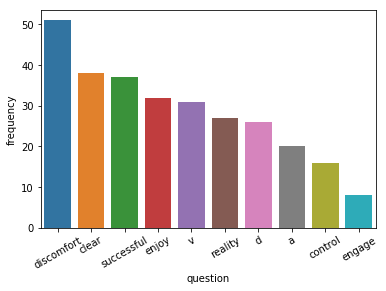

In [28]:
g = sns.barplot(x="question", y="frequency", data=freq_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

In [29]:
sel_acc_list.sort(key=lambda t: t[1], reverse=True)
top_five = sel_acc_list[0:5]
for t in top_five:
    print("selection:", t[0], "- acc:", t[1])

selection: ['control', 'clear', 'reality'] - acc: 0.8601190476190477
selection: ['clear', 'a'] - acc: 0.8348214285714286
selection: ['clear', 'discomfort', 'reality', 'v', 'd'] - acc: 0.8348214285714286
selection: ['clear', 'discomfort', 'a'] - acc: 0.8303571428571428
selection: ['enjoy', 'clear', 'discomfort', 'a'] - acc: 0.8303571428571428


### Random Forest

In [31]:
questions = ["engage", "enjoy", "successful", "control", "clear", "discomfort", "reality", "v", "a", "d"]
four_fold = StratifiedKFold(n_splits=4)
y = v2_diff["task"]

In [32]:
features_list = []
sel_acc_list = []
for L in range(1, len(questions)+1):
    for s in itertools.combinations(questions, L):
        selection = list(s)
        X = v2_diff[selection]
        cv_score = cross_val_score(RandomForestClassifier(), X, y, cv=four_fold, scoring='accuracy').mean()
        if cv_score >= 0.8:
            print("selection:", selection, " - accuracy:", cv_score)
            features_list += selection 
            sel_acc_list.append((selection, cv_score))

selection: ['successful', 'clear']  - accuracy: 0.8601190476190477
selection: ['control', 'clear']  - accuracy: 0.8080357142857143
selection: ['control', 'discomfort']  - accuracy: 0.824404761904762
selection: ['control', 'a']  - accuracy: 0.824404761904762
selection: ['successful', 'control', 'clear']  - accuracy: 0.9017857142857143
selection: ['successful', 'clear', 'd']  - accuracy: 0.824404761904762
selection: ['successful', 'discomfort', 'a']  - accuracy: 0.855654761904762
selection: ['control', 'clear', 'reality']  - accuracy: 0.8392857142857143
selection: ['control', 'clear', 'v']  - accuracy: 0.8392857142857143
selection: ['clear', 'discomfort', 'reality']  - accuracy: 0.8035714285714286
selection: ['engage', 'control', 'discomfort', 'a']  - accuracy: 0.824404761904762
selection: ['enjoy', 'control', 'clear', 'discomfort']  - accuracy: 0.824404761904762
selection: ['enjoy', 'control', 'clear', 'a']  - accuracy: 0.824404761904762
selection: ['enjoy', 'control', 'discomfort', 're

In [33]:
freq_counter = collections.Counter(features_list)
freq_df = pd.DataFrame({"question":list(freq_counter.keys()), "frequency":list(freq_counter.values())})
freq_df = freq_df.sort_values("frequency", ascending=False)
freq_df.reset_index(drop=True, inplace=True)
freq_df.head()

frequency    question
0         62     control
1         55       clear
2         39  successful
3         37     reality
4         34           a

[Text(0,0,'control'),
 Text(0,0,'clear'),
 Text(0,0,'successful'),
 Text(0,0,'reality'),
 Text(0,0,'a'),
 Text(0,0,'discomfort'),
 Text(0,0,'v'),
 Text(0,0,'d'),
 Text(0,0,'enjoy'),
 Text(0,0,'engage')]

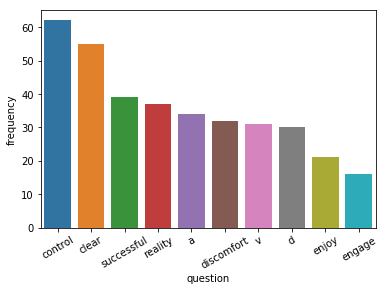

In [34]:
g = sns.barplot(x="question", y="frequency", data=freq_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

In [35]:
sel_acc_list.sort(key=lambda t: t[1], reverse=True)
top_five = sel_acc_list[0:5]
for t in top_five:
    print("selection:", t[0], "- acc:", t[1])

selection: ['successful', 'control', 'clear'] - acc: 0.9017857142857143
selection: ['successful', 'control', 'clear', 'discomfort', 'reality'] - acc: 0.9017857142857143
selection: ['successful', 'control', 'clear', 'discomfort', 'reality', 'v', 'd'] - acc: 0.8973214285714286
selection: ['control', 'clear', 'reality', 'a', 'd'] - acc: 0.8705357142857143
selection: ['successful', 'control', 'clear', 'discomfort'] - acc: 0.8660714285714286


## video 4

### Logistic Regression

In [36]:
v4_diff["task"].value_counts()

1    15
0    14
Name: task, dtype: int64

In [37]:
questions = ["engage", "enjoy", "successful", "control", "clear", "discomfort", "reality", "v", "a", "d"]
four_fold = StratifiedKFold(n_splits=4)
y = v4_diff["task"]

In [38]:
features_list = []
sel_acc_list = []
for L in range(1, len(questions)+1):
    for s in itertools.combinations(questions, L):
        selection = list(s)
        X = v4_diff[selection]
        cv_score = cross_val_score(LogisticRegression(), X, y, cv=four_fold, scoring='accuracy').mean()
        if cv_score >= 0.8:
            print("selection:", selection, " - accuracy:", cv_score)
            features_list += selection 
            sel_acc_list.append((selection, cv_score))

selection: ['successful']  - accuracy: 0.8660714285714286
selection: ['control']  - accuracy: 0.9270833333333334
selection: ['engage', 'successful']  - accuracy: 0.8660714285714286
selection: ['engage', 'control']  - accuracy: 0.855654761904762
selection: ['enjoy', 'successful']  - accuracy: 0.8660714285714286
selection: ['enjoy', 'control']  - accuracy: 0.8601190476190477
selection: ['successful', 'control']  - accuracy: 0.8973214285714286
selection: ['successful', 'clear']  - accuracy: 0.8973214285714286
selection: ['successful', 'discomfort']  - accuracy: 0.8660714285714286
selection: ['successful', 'reality']  - accuracy: 0.8660714285714286
selection: ['successful', 'v']  - accuracy: 0.8973214285714286
selection: ['successful', 'a']  - accuracy: 0.8660714285714286
selection: ['successful', 'd']  - accuracy: 0.8973214285714286
selection: ['control', 'clear']  - accuracy: 0.8601190476190477
selection: ['control', 'discomfort']  - accuracy: 0.855654761904762
selection: ['control', 're

selection: ['engage', 'control', 'discomfort', 'v']  - accuracy: 0.8303571428571428
selection: ['engage', 'control', 'reality', 'v']  - accuracy: 0.8616071428571428
selection: ['engage', 'control', 'v', 'd']  - accuracy: 0.8199404761904762
selection: ['engage', 'control', 'a', 'd']  - accuracy: 0.824404761904762
selection: ['engage', 'clear', 'discomfort', 'd']  - accuracy: 0.8199404761904762
selection: ['enjoy', 'successful', 'control', 'clear']  - accuracy: 0.8973214285714286
selection: ['enjoy', 'successful', 'control', 'discomfort']  - accuracy: 0.8973214285714286
selection: ['enjoy', 'successful', 'control', 'reality']  - accuracy: 0.8973214285714286
selection: ['enjoy', 'successful', 'control', 'v']  - accuracy: 0.8973214285714286
selection: ['enjoy', 'successful', 'control', 'a']  - accuracy: 0.8973214285714286
selection: ['enjoy', 'successful', 'control', 'd']  - accuracy: 0.855654761904762
selection: ['enjoy', 'successful', 'clear', 'discomfort']  - accuracy: 0.897321428571428

selection: ['engage', 'enjoy', 'control', 'discomfort', 'v']  - accuracy: 0.8616071428571428
selection: ['engage', 'enjoy', 'control', 'reality', 'v']  - accuracy: 0.8616071428571428
selection: ['engage', 'enjoy', 'control', 'reality', 'a']  - accuracy: 0.824404761904762
selection: ['engage', 'enjoy', 'control', 'reality', 'd']  - accuracy: 0.824404761904762
selection: ['engage', 'enjoy', 'control', 'v', 'a']  - accuracy: 0.8199404761904762
selection: ['engage', 'enjoy', 'control', 'v', 'd']  - accuracy: 0.8199404761904762
selection: ['engage', 'enjoy', 'control', 'a', 'd']  - accuracy: 0.824404761904762
selection: ['engage', 'successful', 'control', 'clear', 'discomfort']  - accuracy: 0.8973214285714286
selection: ['engage', 'successful', 'control', 'clear', 'reality']  - accuracy: 0.855654761904762
selection: ['engage', 'successful', 'control', 'clear', 'v']  - accuracy: 0.8973214285714286
selection: ['engage', 'successful', 'control', 'clear', 'a']  - accuracy: 0.8973214285714286
se

selection: ['successful', 'control', 'clear', 'discomfort', 'reality']  - accuracy: 0.855654761904762
selection: ['successful', 'control', 'clear', 'discomfort', 'v']  - accuracy: 0.8973214285714286
selection: ['successful', 'control', 'clear', 'discomfort', 'a']  - accuracy: 0.8973214285714286
selection: ['successful', 'control', 'clear', 'discomfort', 'd']  - accuracy: 0.855654761904762
selection: ['successful', 'control', 'clear', 'reality', 'v']  - accuracy: 0.855654761904762
selection: ['successful', 'control', 'clear', 'reality', 'a']  - accuracy: 0.8973214285714286
selection: ['successful', 'control', 'clear', 'reality', 'd']  - accuracy: 0.8139880952380952
selection: ['successful', 'control', 'clear', 'v', 'a']  - accuracy: 0.8973214285714286
selection: ['successful', 'control', 'clear', 'v', 'd']  - accuracy: 0.855654761904762
selection: ['successful', 'control', 'clear', 'a', 'd']  - accuracy: 0.855654761904762
selection: ['successful', 'control', 'discomfort', 'reality', 'v'

selection: ['engage', 'successful', 'control', 'clear', 'discomfort', 'reality']  - accuracy: 0.855654761904762
selection: ['engage', 'successful', 'control', 'clear', 'discomfort', 'v']  - accuracy: 0.8973214285714286
selection: ['engage', 'successful', 'control', 'clear', 'discomfort', 'a']  - accuracy: 0.8973214285714286
selection: ['engage', 'successful', 'control', 'clear', 'discomfort', 'd']  - accuracy: 0.855654761904762
selection: ['engage', 'successful', 'control', 'clear', 'reality', 'v']  - accuracy: 0.855654761904762
selection: ['engage', 'successful', 'control', 'clear', 'reality', 'a']  - accuracy: 0.855654761904762
selection: ['engage', 'successful', 'control', 'clear', 'reality', 'd']  - accuracy: 0.8139880952380952
selection: ['engage', 'successful', 'control', 'clear', 'v', 'a']  - accuracy: 0.8973214285714286
selection: ['engage', 'successful', 'control', 'clear', 'v', 'd']  - accuracy: 0.855654761904762
selection: ['engage', 'successful', 'control', 'clear', 'a', 'd

selection: ['successful', 'control', 'clear', 'discomfort', 'a', 'd']  - accuracy: 0.855654761904762
selection: ['successful', 'control', 'clear', 'reality', 'v', 'a']  - accuracy: 0.8973214285714286
selection: ['successful', 'control', 'clear', 'reality', 'v', 'd']  - accuracy: 0.8973214285714286
selection: ['successful', 'control', 'clear', 'reality', 'a', 'd']  - accuracy: 0.855654761904762
selection: ['successful', 'control', 'clear', 'v', 'a', 'd']  - accuracy: 0.855654761904762
selection: ['successful', 'control', 'discomfort', 'reality', 'v', 'a']  - accuracy: 0.9285714285714286
selection: ['successful', 'control', 'discomfort', 'reality', 'v', 'd']  - accuracy: 0.8139880952380952
selection: ['successful', 'control', 'discomfort', 'reality', 'a', 'd']  - accuracy: 0.8139880952380952
selection: ['successful', 'control', 'discomfort', 'v', 'a', 'd']  - accuracy: 0.855654761904762
selection: ['successful', 'control', 'reality', 'v', 'a', 'd']  - accuracy: 0.855654761904762
selectio

selection: ['enjoy', 'successful', 'control', 'clear', 'v', 'a', 'd']  - accuracy: 0.855654761904762
selection: ['enjoy', 'successful', 'control', 'discomfort', 'reality', 'v', 'a']  - accuracy: 0.9285714285714286
selection: ['enjoy', 'successful', 'control', 'discomfort', 'reality', 'v', 'd']  - accuracy: 0.855654761904762
selection: ['enjoy', 'successful', 'control', 'discomfort', 'reality', 'a', 'd']  - accuracy: 0.8139880952380952
selection: ['enjoy', 'successful', 'control', 'discomfort', 'v', 'a', 'd']  - accuracy: 0.855654761904762
selection: ['enjoy', 'successful', 'control', 'reality', 'v', 'a', 'd']  - accuracy: 0.855654761904762
selection: ['enjoy', 'successful', 'clear', 'discomfort', 'reality', 'v', 'd']  - accuracy: 0.8139880952380952
selection: ['enjoy', 'successful', 'clear', 'discomfort', 'reality', 'a', 'd']  - accuracy: 0.8139880952380952
selection: ['enjoy', 'successful', 'clear', 'reality', 'v', 'a', 'd']  - accuracy: 0.8139880952380952
selection: ['enjoy', 'succes

In [39]:
freq_counter = collections.Counter(features_list)
freq_df = pd.DataFrame({"question":list(freq_counter.keys()), "frequency":list(freq_counter.values())})
freq_df = freq_df.sort_values("frequency", ascending=False)
freq_df.reset_index(drop=True, inplace=True)
freq_df.head()

frequency    question
0        467  successful
1        435     control
2        344           v
3        318  discomfort
4        317       enjoy

[Text(0,0,'successful'),
 Text(0,0,'control'),
 Text(0,0,'v'),
 Text(0,0,'discomfort'),
 Text(0,0,'enjoy'),
 Text(0,0,'d'),
 Text(0,0,'clear'),
 Text(0,0,'reality'),
 Text(0,0,'a'),
 Text(0,0,'engage')]

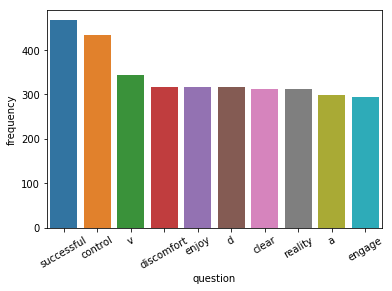

In [40]:
g = sns.barplot(x="question", y="frequency", data=freq_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

In [41]:
sel_acc_list.sort(key=lambda t: t[1], reverse=True)
top_five = sel_acc_list[0:5]
for t in top_five:
    print("selection:", t[0], "- acc:", t[1])

selection: ['enjoy', 'control', 'reality', 'v'] - acc: 0.9642857142857143
selection: ['control', 'reality', 'v'] - acc: 0.9285714285714286
selection: ['control', 'v', 'a'] - acc: 0.9285714285714286
selection: ['successful', 'control', 'reality', 'a'] - acc: 0.9285714285714286
selection: ['enjoy', 'successful', 'control', 'reality', 'a'] - acc: 0.9285714285714286


### Random Forest

In [42]:
questions = ["engage", "enjoy", "successful", "control", "clear", "discomfort", "reality", "v", "a", "d"]
four_fold = StratifiedKFold(n_splits=4)
y = v4_diff["task"]

In [43]:
features_list = []
sel_acc_list = []
for L in range(1, len(questions)+1):
    for s in itertools.combinations(questions, L):
        selection = list(s)
        X = v4_diff[selection]
        cv_score = cross_val_score(RandomForestClassifier(), X, y, cv=four_fold, scoring='accuracy').mean()
        if cv_score >= 0.8:
            print("selection:", selection, " - accuracy:", cv_score)
            features_list += selection
            sel_acc_list.append((selection, cv_score))

selection: ['control']  - accuracy: 1.0
selection: ['engage', 'successful']  - accuracy: 0.8660714285714286
selection: ['engage', 'control']  - accuracy: 0.9583333333333334
selection: ['enjoy', 'control']  - accuracy: 0.96875
selection: ['successful', 'control']  - accuracy: 0.8973214285714286
selection: ['successful', 'clear']  - accuracy: 0.8660714285714286
selection: ['successful', 'discomfort']  - accuracy: 0.824404761904762
selection: ['successful', 'v']  - accuracy: 0.8035714285714286
selection: ['successful', 'd']  - accuracy: 0.8035714285714286
selection: ['control', 'clear']  - accuracy: 0.9330357142857143
selection: ['control', 'discomfort']  - accuracy: 0.8973214285714286
selection: ['control', 'reality']  - accuracy: 0.9330357142857143
selection: ['control', 'v']  - accuracy: 0.96875
selection: ['control', 'a']  - accuracy: 0.96875
selection: ['control', 'd']  - accuracy: 0.9270833333333334
selection: ['engage', 'enjoy', 'successful']  - accuracy: 0.8616071428571428
selecti

selection: ['enjoy', 'successful', 'control', 'd']  - accuracy: 0.9375
selection: ['enjoy', 'successful', 'clear', 'discomfort']  - accuracy: 0.8035714285714286
selection: ['enjoy', 'successful', 'clear', 'v']  - accuracy: 0.8660714285714286
selection: ['enjoy', 'successful', 'clear', 'a']  - accuracy: 0.8660714285714286
selection: ['enjoy', 'successful', 'clear', 'd']  - accuracy: 0.8660714285714286
selection: ['enjoy', 'successful', 'discomfort', 'v']  - accuracy: 0.8348214285714286
selection: ['enjoy', 'successful', 'discomfort', 'd']  - accuracy: 0.8348214285714286
selection: ['enjoy', 'successful', 'reality', 'a']  - accuracy: 0.855654761904762
selection: ['enjoy', 'successful', 'reality', 'd']  - accuracy: 0.8973214285714286
selection: ['enjoy', 'control', 'clear', 'discomfort']  - accuracy: 1.0
selection: ['enjoy', 'control', 'clear', 'reality']  - accuracy: 0.96875
selection: ['enjoy', 'control', 'clear', 'v']  - accuracy: 0.96875
selection: ['enjoy', 'control', 'clear', 'a']  

selection: ['engage', 'successful', 'control', 'clear', 'd']  - accuracy: 0.96875
selection: ['engage', 'successful', 'control', 'discomfort', 'reality']  - accuracy: 0.96875
selection: ['engage', 'successful', 'control', 'discomfort', 'v']  - accuracy: 0.9330357142857143
selection: ['engage', 'successful', 'control', 'discomfort', 'a']  - accuracy: 0.8973214285714286
selection: ['engage', 'successful', 'control', 'discomfort', 'd']  - accuracy: 0.8973214285714286
selection: ['engage', 'successful', 'control', 'reality', 'v']  - accuracy: 0.8973214285714286
selection: ['engage', 'successful', 'control', 'reality', 'a']  - accuracy: 0.96875
selection: ['engage', 'successful', 'control', 'reality', 'd']  - accuracy: 0.96875
selection: ['engage', 'successful', 'control', 'v', 'a']  - accuracy: 0.8973214285714286
selection: ['engage', 'successful', 'control', 'v', 'd']  - accuracy: 0.855654761904762
selection: ['engage', 'successful', 'control', 'a', 'd']  - accuracy: 0.96875
selection: ['

selection: ['successful', 'control', 'clear', 'reality', 'a']  - accuracy: 0.96875
selection: ['successful', 'control', 'clear', 'reality', 'd']  - accuracy: 0.8973214285714286
selection: ['successful', 'control', 'clear', 'v', 'a']  - accuracy: 0.8973214285714286
selection: ['successful', 'control', 'clear', 'v', 'd']  - accuracy: 0.96875
selection: ['successful', 'control', 'clear', 'a', 'd']  - accuracy: 0.9330357142857143
selection: ['successful', 'control', 'discomfort', 'reality', 'v']  - accuracy: 0.96875
selection: ['successful', 'control', 'discomfort', 'reality', 'a']  - accuracy: 0.96875
selection: ['successful', 'control', 'discomfort', 'reality', 'd']  - accuracy: 0.96875
selection: ['successful', 'control', 'discomfort', 'v', 'a']  - accuracy: 0.96875
selection: ['successful', 'control', 'discomfort', 'v', 'd']  - accuracy: 0.855654761904762
selection: ['successful', 'control', 'discomfort', 'a', 'd']  - accuracy: 0.96875
selection: ['successful', 'control', 'reality', 'v

selection: ['engage', 'successful', 'control', 'clear', 'reality', 'a']  - accuracy: 0.96875
selection: ['engage', 'successful', 'control', 'clear', 'reality', 'd']  - accuracy: 0.8973214285714286
selection: ['engage', 'successful', 'control', 'clear', 'v', 'a']  - accuracy: 0.8973214285714286
selection: ['engage', 'successful', 'control', 'clear', 'v', 'd']  - accuracy: 0.855654761904762
selection: ['engage', 'successful', 'control', 'clear', 'a', 'd']  - accuracy: 0.8973214285714286
selection: ['engage', 'successful', 'control', 'discomfort', 'reality', 'v']  - accuracy: 0.8973214285714286
selection: ['engage', 'successful', 'control', 'discomfort', 'reality', 'a']  - accuracy: 0.8660714285714286
selection: ['engage', 'successful', 'control', 'discomfort', 'reality', 'd']  - accuracy: 1.0
selection: ['engage', 'successful', 'control', 'discomfort', 'v', 'a']  - accuracy: 0.8973214285714286
selection: ['engage', 'successful', 'control', 'discomfort', 'v', 'd']  - accuracy: 0.897321428

selection: ['successful', 'clear', 'discomfort', 'reality', 'v', 'd']  - accuracy: 0.8616071428571428
selection: ['successful', 'clear', 'discomfort', 'reality', 'a', 'd']  - accuracy: 0.8199404761904762
selection: ['successful', 'clear', 'discomfort', 'v', 'a', 'd']  - accuracy: 0.8199404761904762
selection: ['control', 'clear', 'discomfort', 'reality', 'v', 'a']  - accuracy: 0.8973214285714286
selection: ['control', 'clear', 'discomfort', 'reality', 'v', 'd']  - accuracy: 0.9270833333333334
selection: ['control', 'clear', 'discomfort', 'reality', 'a', 'd']  - accuracy: 0.9270833333333334
selection: ['control', 'clear', 'discomfort', 'v', 'a', 'd']  - accuracy: 0.96875
selection: ['control', 'clear', 'reality', 'v', 'a', 'd']  - accuracy: 0.8541666666666666
selection: ['control', 'discomfort', 'reality', 'v', 'a', 'd']  - accuracy: 0.9642857142857143
selection: ['engage', 'enjoy', 'successful', 'control', 'clear', 'discomfort', 'reality']  - accuracy: 0.96875
selection: ['engage', 'en

selection: ['enjoy', 'successful', 'control', 'discomfort', 'reality', 'v', 'd']  - accuracy: 0.9330357142857143
selection: ['enjoy', 'successful', 'control', 'discomfort', 'reality', 'a', 'd']  - accuracy: 0.855654761904762
selection: ['enjoy', 'successful', 'control', 'discomfort', 'v', 'a', 'd']  - accuracy: 1.0
selection: ['enjoy', 'successful', 'control', 'reality', 'v', 'a', 'd']  - accuracy: 0.9330357142857143
selection: ['enjoy', 'successful', 'clear', 'discomfort', 'reality', 'v', 'a']  - accuracy: 0.8199404761904762
selection: ['enjoy', 'successful', 'clear', 'discomfort', 'reality', 'v', 'd']  - accuracy: 0.8258928571428571
selection: ['enjoy', 'successful', 'clear', 'reality', 'v', 'a', 'd']  - accuracy: 0.8303571428571428
selection: ['enjoy', 'control', 'clear', 'discomfort', 'reality', 'v', 'a']  - accuracy: 0.9642857142857143
selection: ['enjoy', 'control', 'clear', 'discomfort', 'reality', 'v', 'd']  - accuracy: 0.8616071428571428
selection: ['enjoy', 'control', 'clear'

In [44]:
freq_counter = collections.Counter(features_list)
freq_df = pd.DataFrame({"question":list(freq_counter.keys()), "frequency":list(freq_counter.values())})
freq_df = freq_df.sort_values("frequency", ascending=False)
freq_df.reset_index(drop=True, inplace=True)
freq_df.head()

frequency    question
0        507     control
1        387  successful
2        330       clear
3        323           v
4        319  discomfort

[Text(0,0,'control'),
 Text(0,0,'successful'),
 Text(0,0,'clear'),
 Text(0,0,'v'),
 Text(0,0,'discomfort'),
 Text(0,0,'d'),
 Text(0,0,'reality'),
 Text(0,0,'engage'),
 Text(0,0,'enjoy'),
 Text(0,0,'a')]

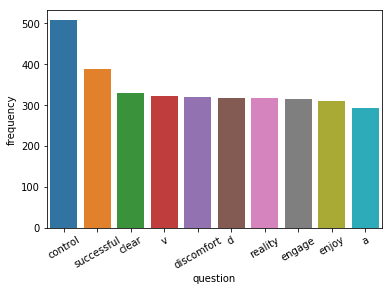

In [45]:
g = sns.barplot(x="question", y="frequency", data=freq_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

In [46]:
sel_acc_list.sort(key=lambda t: t[1], reverse=True)
top_five = sel_acc_list[0:5]
for t in top_five:
    print("selection:", t[0], "- acc:", t[1])

selection: ['control'] - acc: 1.0
selection: ['engage', 'enjoy', 'control', 'v'] - acc: 1.0
selection: ['engage', 'control', 'clear', 'v'] - acc: 1.0
selection: ['engage', 'control', 'reality', 'd'] - acc: 1.0
selection: ['engage', 'control', 'v', 'a'] - acc: 1.0
